# Ant Colony Optimization


Ant Colony Optimization (ACO), like Particle Swarm Optimization (PSO), is a metaheuristic technique inspired by natural processes to solve optimization problems. ACO algorithms, first introduced in the seminal work by Dorigo, Maniezzo, and Colorni titled *Ant System* ([1996](https://ieeexplore.ieee.org/document/484436)), imitate real ants' behavior in finding the shortest path between their colony and a food source. One particularly interesting behavior of ants is that some species, even blind ones, can locate the shortest path by depositing a chemical substance known as *pheromone* as they move. When an ant does not detect any pheromone, its movement appears random. However, in the presence of pheromones, ants tend to follow paths with higher pheromone concentrations. As each ant deposits its own pheromone during its journey, a feedback loop forms, strengthening the path over time.

Ants are able to identify the shortest path because those following shorter routes can complete more trips, resulting in increased pheromone deposition along that path. The system includes pheromone evaporation, which reduces the attractiveness of less optimal paths, ensuring the colony avoids suboptimal solutions.

### Problems Solved by ACO

ACO algorithms are primarily used to tackle combinatorial optimization problems, such as the [knapsack problem](https://en.wikipedia.org/wiki/Knapsack_problem), the [vehicle routing problem](https://en.wikipedia.org/wiki/Vehicle_routing_problem), and the [travelling salesman problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem). These algorithms are typically applied to discrete decision spaces, although continuous decision space versions also exist. In many cases, the problem is represented as a graph $G=(N, A)$, where $N$ is the set of nodes and $A$ represents the edges connecting them. Each edge $a \in A$ has an associated transition cost $c_{rs}$ (moving between nodes $r$ and $s$), along with two types of information:

- **Heuristic information** ($\eta_{rs}$): Problem-specific data that remains constant throughout.
- **Pheromone trail information** ($\tau_{rs}$): A dynamic value representing the collective knowledge learned by the ants over time.

### The Artificial Ant

Artificial ants, which simulate real ants' behavior, have several key properties aimed at finding the minimum cost solution for a problem:

- **Memory ($L$)**: This stores the ant’s traveled path, which can be used to generate new solutions, assess the current one, or retrace the ant’s steps.
- **Initial state ($\delta_{initial}$)**: Defined according to the problem at hand.
- **Movement**: At time $t$, the ant's state is $\delta_r = <\delta_{t-1}, r>$, where $r$ is its current location. From $r$, the ant can move to any other location $s \in \mathcal{N}(r)$, where $\mathcal{N}(r) = \{s | a_{rs} \in A \text{ and } <\delta_r, s> \in \tilde{\Delta}\}$ represents the feasible neighbors of $r$.
- **Transition rule**: The selection of $s \in \mathcal{N}(r)$ depends on various factors such as pheromone trails, heuristic values, private memory, or random choices.
- **Online step-by-step pheromone trail update**: As the ant moves from $r \to s$, it updates the pheromone trail $\tau_{rs}$.
- **Online delayed pheromone trail update**: After reaching its objective, the ant can retrace its path, updating the pheromone trail along the way.
- **Offline pheromone trail update**: These updates, called *daemon actions*, are based on global knowledge of the colony, not individual ants. They have no equivalent in nature.

Unlike real ants, artificial ants can adjust the strength of their pheromone updates based on the quality of the solutions they find. Additionally, different ACO models employ one or more types of pheromone updates (online, online delayed, or offline). Pheromone evaporation is also implemented to prevent the algorithm from getting stuck in local optima.

The following diagram outlines the generic structure of an ACO algorithm, as described in a review paper by Dorigo et al. ([source](https://www.researchgate.net/publication/28246325_A_review_on_the_ant_colony_optimization_metaheuristic_Basis_models_and_new_trends)):

![Generic ACO algorithm structure](Images/ACO_generic.png)

### Ant Colony Optimization Models

Several models of ACO have been developed over time, each improving upon the original *Ant System*:

1. **Ant System**: The foundational model introduced by Dorigo et al. ([source](https://ieeexplore.ieee.org/document/484436)). The transition probability for an ant to move from node $r$ to $s$ is given by:

   $$p^k_{rs} = \frac{[\tau_{rs}]^\alpha \cdot [\eta_{rs}]^\beta}{\sum_{u \in \mathcal{N}^k_r} [\tau_{ru}]^\alpha \cdot [\eta_{ru}]^\beta}$$

   where $\alpha$ and $\beta$ control the influence of the pheromone trail and heuristic information, respectively. At each iteration, a portion of the pheromone evaporates:

   $$\tau_{rs} \leftarrow (1-\rho) \tau_{rs}$$

   where $\rho$ is the evaporation rate. Afterward, ants update the pheromone trail via an online delayed update:

   $$\tau_{rs} \leftarrow \tau_{rs} + f(C(S_k))$$

   where $C(S_k)$ reflects the quality of the solution $S_k$.

2. **Ant Colony System**: Modifies the transition rule by incorporating pseudo-random selection, resembling epsilon-greedy strategies in reinforcement learning. Additionally, it decreases the pheromone trail as an ant traverses an edge, encouraging exploration ([source](https://people.idsia.ch/~luca/acs-ec97.pdf)).

3. **Max-Min Ant System**: Limits the pheromone trail values within a specified range, ensuring neither excessively low nor high pheromone values dominate ([source](https://link.springer.com/chapter/10.1007/978-3-7091-6492-1_54)).

4. **Rank-based Ant System**: Ranks $m$ ants based on solution quality and applies pheromone updates based on these ranks ([source](https://epub.wu.ac.at/616/1/document.pdf)).

5. **Best-Worst Ant System**: Combines ACO with evolutionary computation concepts by penalizing the worst solution found and mutating pheromone trails based on a probability ([source](https://www.researchgate.net/publication/313071572_A_new_ACO_model_integrating_evolutionary_computation_concepts_The_best-worst_ant_system)).

### Code Implementation

Key features of ACO code implementations include:

- **Pheromone evaporation**: The pheromone value updates as $\tau_{rs} \leftarrow (1-\rho) \tau_{rs}$, where $\rho$ is the evaporation factor.
- **Stochastic transition rate**: The transition is determined stochastically based on an `explore_rate`. If a random number $r<$`explore_rate`, transitions are selected probabilistically; otherwise, the best path is chosen.
- **Intensification of pheromone**: For the best solution of each iteration, pheromones are reinforced.
- **Heuristic factor decay**: The importance of the heuristic parameter $\beta$ decreases over time, allowing the ants to rely more on the learned pheromone trails.
- **Parallel processing**: Multiple ants can be executed simultaneously in each iteration, utilizing multi-processing to improve computational efficiency.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
from multiprocessing import cpu_count
from multiprocessing.pool import ThreadPool

In [ ]:
class ACO:
    def __init__(self, dist_matrix, n_ants, alpha, beta, evaporation_rate, intensification, beta_evapouration_rate=0.0, explore_rate=0.9, n_jobs=1):
        '''
        Ant colony optimizer deisgned to minimize the distance travelled while traversing a graph.
        :param dist_matrix: n x n matrix of distances between nodes
        :param n_ants: number of ants in colony
        :param alpha: preference for pheromone
        :param beta: preference for heuristic
        :param evaporation_rate: rate at which phermone evaporates
        :param intensification: daemon task of adding constant to best path
        :param beta_evaporation_rate: rate at which the heuristic value decays, default 0
        :param explore_rate: probability of choosing a random next node based on transition probablity, default 0.9
        :param n_jobs: number of parallel ants to run
        '''
        self.n_ants, self.alpha, self.beta, self.evap_r = n_ants, alpha, beta, evaporation_rate
        self.intensification, self.beta_evap_r, self.explore_r = intensification, beta_evapouration_rate, explore_rate

        self.fit, self.best_path, self.best_score, self.best_per_it = False, None, np.inf, []

        assert dist_matrix.shape[0] == dist_matrix.shape[1], "dist_matrix must be square!"
        self.map = dist_matrix
        n_nodes = dist_matrix.shape[0]
        self.pheromone_matrix = np.ones((n_nodes, n_nodes))
        self.pheromone_matrix[np.eye(n_nodes)==1] = 0.0
        self.heuristic_matrix = 1/self.map
        self.transition_prob = (self.pheromone_matrix ** self.alpha) * (self.heuristic_matrix ** self.beta)
        self.score_path = self.score_path_rotated if n_nodes>70 else self.score_path_bruteloop
        if n_jobs==-1:
            self.n_jobs = cpu_count()
        else:
            self.n_jobs = n_jobs
        self.pool = ThreadPool(self.n_jobs)
        self.best_path_hist = []

    def get_next_node(self, curr, nodes_left):
        '''
        Get the next node based on the current node and nodes left to traverse.
        If p < explore_rate, then select next from probability ditribution over remaining nodes
        Else, select node with least transition probability
        :param curr: current node
        :param nodes_left: nodes left to traverse by particular ant
        :return: node to traverse to
        '''
        num = self.transition_prob[curr, nodes_left]
        if np.random.rand() < self.explore_r:
            return np.random.choice(nodes_left, p=num/np.sum(num))
        else:
            return nodes_left[np.argmax(num)]

    def score_path_rotated(self, path):
        '''
        Get quality of path
        :param path: list of node indices travelled in sequence
        :return score:
        '''
        rotated_path = path.copy()
        rotated_path.append(rotated_path.pop(0))
        return np.sum(self.map[path, rotated_path])     # faster than if loop if n_nodes > ~70

    def score_path_bruteloop(self, path):
        '''
        Get quality of path
        :param path: list of node indices travelled in sequence
        :return score:
        '''
        score = 0
        for i in range(len(path) - 1):
            score += self.map[path[i], path[i + 1]]
        return score + self.map[path[-1], path[0]]     # faster if n_nodes < ~70


    def start_and_run_ant(self, ant_id):
        nodes_left = list(range(self.map.shape[0]))
        node_start = np.random.randint(0, len(nodes_left))
        node_curr, path = node_start, [node_start]
        nodes_left.remove(node_curr)

        while nodes_left:
            node_curr = self.get_next_node(node_curr, nodes_left)
            path.append(node_curr)
            nodes_left.remove(node_curr)
        return path, self.score_path(path)

    def evapourate(self):
        '''
        Evapourate the pheromone using the evapouration rate. Also reduce beta as required
        '''
        self.pheromone_matrix *= (1-self.evap_r)
        self.beta *= (1-self.beta_evap_r)

    def intensify(self, path):
        '''
        Add extra pheromone to the path given
        :param path: path which achieved best result in that iteration
        '''
        rotated_path = path.copy()
        rotated_path.append(rotated_path.pop(0))
        self.pheromone_matrix[path, rotated_path] += self.intensification

    def update_transition_probs(self):
        self.transition_prob = (self.pheromone_matrix**self.alpha) * (self.heuristic_matrix**self.beta)

    def run(self, max_iter=100, early_stop=20):
        '''
        Run the ACO algorithm
        :param max_iter: Maximum number of iterations allowed
        :param early_stop: If best score does not change for early_stop iterations, stop
        '''
        same_result = 0
        start_t = time.time()
        for i in range(max_iter):
            parallel_results = self.pool.map(self.start_and_run_ant, np.arange(self.n_ants))
            iter_paths, iter_scores = zip(*parallel_results)
            # iter_paths, iter_scores = [], []
            # for j in range(self.n_ants):

            #     path, score = self.start_and_run_ant(j)
            #     iter_paths.append(path)
            #     iter_scores.append(score)
            best_ant = np.argmin(iter_scores)
            iter_best_path, iter_best_score = iter_paths[best_ant], iter_scores[best_ant]
            self.best_per_it.append(iter_best_score)
            if iter_best_score < self.best_score:
                self.best_score = iter_best_score
                self.best_path = iter_best_path.copy()
                same_result = 0
            elif iter_best_score == self.best_score:
                same_result += 1
            else:
                same_result = 0


            self.evapourate()
            self.intensify(iter_best_path)
            self.update_transition_probs()
            self.best_path_hist.append(self.best_path.copy())

            if same_result > early_stop:
                print('No change for the last {} iterations... stopping'.format(early_stop))
                break
        self.fit = True
        self.fit_time = time.time() - start_t
        return self.best_path, self.best_score

    def plot(self):
        if not self.fit:
            print('Optimization not yet run!')
        else:
            plt.plot(self.best_per_it, label="Best Run")
            plt.xlabel("Iteration")
            plt.ylabel("Performance")
            plt.text(.8, .6,
                    'Ants: {}\nEvap Rate: {}\nIntensify: {}\nAlpha: {}\nBeta: {}\nBeta Evap: {}\nExplore Rate: {}\n\nFit Time: {}m'.format(
                        self.n_ants, self.evap_r, self.intensification, self.alpha,
                        self.beta, self.evap_r, self.explore_r, self.fit_time // 60),
                    bbox={'facecolor': 'gray', 'alpha': 0.8, 'pad': 10})
            plt.legend()
            plt.title("Ant Colony Optimization Results (best: {})".format(np.round(self.best_score, 2)))

## Solving TSP with ACO

In [ ]:
class TravelSalesPerson(object):
    def __init__(self, n_cities, max_coor = 1):
        self.city_position = np.random.rand(n_cities, 2)*max_coor
        self.iter = 0
        self.n_cities = n_cities
        self.max_coor = max_coor

        '''Calculates the total distance travelled when visiting the cities in the order provided.
        :param visit_order: (Nxd) matrix of N possible permutations of d cities
        :return dist: (1xN) vector of total distances travelled for each permutation
        '''
    def cost(self, visit_order):

        if visit_order.shape[1] != self.n_cities:
            raise Exception("visit_order should have dim[1] = number of cities")
        dist = np.zeros(visit_order.shape[0])
        for i in range(self.n_cities-1):
            dist += np.linalg.norm(self.city_position[visit_order[:, i], :] - self.city_position[visit_order[:, i+1], :], axis=1)

        dist += np.linalg.norm(self.city_position[visit_order[:, -1], :] - self.city_position[visit_order[:, 0], :], axis=1)
        return dist


        '''Get the distance matrix for all cities
        :return dist: (NxN) matrix of total distances travelled for each permutation
        '''
    def get_dist_mat(self):
        dist = np.ones((self.n_cities, self.n_cities))
        for i in range(self.n_cities-1):
            for j in range(i+1, self.n_cities):
                dist[i,j] = np.linalg.norm(self.city_position[i, :] - self.city_position[j, :])
        i_lower = np.tril_indices(self.n_cities)
        dist[i_lower] = dist.T[i_lower]
        return dist

    def plotting(self, order, cost, save=False):
        plt.cla()
        plt.scatter(self.city_position[:, 0].T, self.city_position[:, 1].T, s=10, c='k')
        lx, ly = self.city_position[order, 0], self.city_position[order, 1]
        plt.plot(lx.T, ly.T, 'r-')
        plt.text(-0.05, -0.05, "Total distance=%.2f" % cost, fontdict={'size': 20, 'color': 'red'})
        # plt.xlim((-0.1, 1.1))
        # plt.ylim((-0.1, 1.1))
        if save: plt.savefig('Images/travelling_salesman/travelling_salesman_{:03d}'.format(self.iter))
        # if self.iter%100==0: plt.show()
        self.iter += 1

In [ ]:
N_CITIES = 100
tsp = TravelSalesPerson(N_CITIES, max_coor=10)
aco = ACO(tsp.get_dist_mat(), n_ants=30, alpha=1, beta=0.5, evaporation_rate=0.1, intensification=2, explore_rate=0.9, n_jobs=-1)

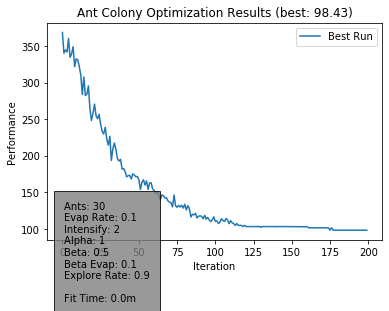

In [ ]:
aco.run(max_iter=200)
aco.plot()

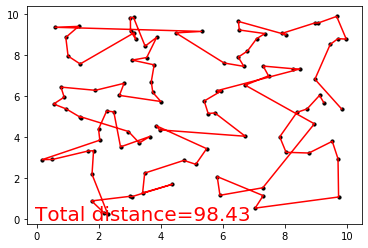

In [ ]:
tsp.plotting(aco.best_path, aco.best_score)